# *k*-Means Clustering

This notebook implements *k*-Means Clustering, an unsupervised learning method primarily used for cluster analysis. It is an iterative process of assigning each data point to the groups, slowly clustering data points based on similar features.

For more details about the algorithm, check out the README of this subdirectory, [here](https://github.com/kary5678/INDE-577/tree/main/unsupervised-learning/k-means_clustering#readme).

---

First, load the relevant libraries needed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set the Seaborn theme and other plotting functionalities
sns.set_theme()
from matplotlib.lines import Line2D

# Import functions to help evaluate performance
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.cluster import KMeans

## The Data

The model will be trained using the [Hawks](https://github.com/kary5678/INDE-577/blob/main/Data/hawks.csv) dataset. This dataset contains observations for three species of hawks, and attributes such as age, sex, wing length, body weight, tail length, etc. 

The code block below reads the dataset into a pandas DataFrame object, subsets the DataFrame to the relevant variables, and drops any rows where there are missing values for these relevant variables.

In [2]:
# Read in the data and subset it to the relevant columns/observations
hawks = pd.read_csv("../../Data/hawks.csv")
hawks = hawks[["Species", "Wing", "Tail", "Weight", "Culmen", "Hallux"]].dropna(axis=0)
hawks

,Species,Wing,Tail,Weight,Culmen,Hallux
0,RT,385.0,219,920.0,25.7,30.1
2,RT,381.0,235,990.0,26.7,31.3
3,CH,265.0,220,470.0,18.7,23.5
4,SS,205.0,157,170.0,12.5,14.3
5,RT,412.0,230,1090.0,28.5,32.2
...,...,...,...,...,...,...
903,RT,380.0,224,1525.0,26.0,27.6
904,SS,190.0,150,175.0,12.7,15.4
905,RT,360.0,211,790.0,21.9,27.6
906,RT,369.0,207,860.0,25.2,28.0


## Using scikit-learn

I will be first be using `KMeans` from the scikit-learn library to understand how *k*-means clustering works.

### Data preparation - wing & tail length

Because I want to plot the results of *k*-means clustering in the 2D space, I am going to just use 2 predictors. Since k-means clustering is an unsupervised learning algorithm that does not require labeled data to learn, the data does not need to be separated the data into a training/testing set.

In [3]:
# Data preparation step
X = hawks[["Wing", "Tail"]]
y = hawks["Species"]

### Selecting an optimal *k*

One underlying question behind *k*-means clustering is the optimal number of clusters or centroids to generate. One way to evaluate this is by obtaining the inertia for each *k*. Inertia is defined as the sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided. The objective of *k*-means clustering is to minimize this sum of all distances.

To find the number of clusters/centroids I need for the hawks data, I will plot the inertia for a range of *k*. This is also known as the elbow method plot.

In [4]:
def plot_elbow_method(X):
    """
    A diagnostic plot to determine the number of clusters, k, in a data set. 
    We want to minimize inertia and select the value of k at the "elbow" of the plot.
    Beyond the elbow, the cost of computation does not outweigh the perfomance gain.
    """
    possible_k = range(2, 11)
    inertias = []
    for k in possible_k:
        sk_kmeans = KMeans(n_clusters = k, random_state = 42)
        sk_kmeans.fit(X)
        inertias.append(sk_kmeans.inertia_)
    plt.figure(figsize = (7, 5))
    plt.plot(possible_k, inertias, color = 'red', marker = "o")
    plt.xlabel("k", fontsize = 12)
    plt.ylabel("Inertia", fontsize = 12)
    plt.xticks(possible_k)

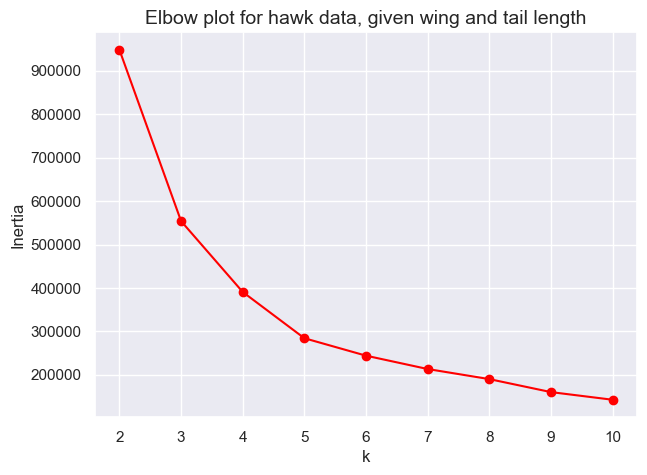

In [5]:
plot_elbow_method(X)
plt.title("Elbow plot for hawk data, given wing and tail length", fontsize = 14)
plt.show()

Based on the elbow method, I will proceed with $k$ = 5. Beyond this point, the decrease in inertia diminishes with an increase in $k$.

### Perform *k*-means clustering (*k* = 5)

Now I will perform *k*-means clustering, with the optimal value of *k*.

In [6]:
sk_kmeans = KMeans(n_clusters = 5, random_state = 42)
sk_kmeans = sk_kmeans.fit(X)

# Per documentation, score() ouputs opposite of the value of X on the k-means objective.
sk_kmeans.score(X) * -1

284429.5183197927

I get the inertia from the elbow plot.

In [7]:
# Print the cluster centers
print(sk_kmeans.cluster_centers_)

[[198.70212766 157.54609929]
 [405.66190476 232.6952381 ]
 [374.61647727 215.98863636]
 [245.60869565 203.57971014]
 [163.79159664 134.94957983]]


The 5 centroids are listed above. To visualize this, I am going to plot the clusters discovered, and then compare them side-by-side with the labels that I already know from the data (technically in an unsupervised learning setting, I would not know the labels and be unable to make this comparison).

In [8]:
def plot_hawk_kmeans(sk_kmeans, X, y):
    """
    Plot the k-means clustering results for the hawk data, comparing the predicted clusters
    side by side with the true clusters observed in the data.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    fig.suptitle("Scatterplot of Hawk Species by Tail vs. Wing Length", fontsize = 15)

    # Plot the data points with different colors representing the different clusters
    labels = sk_kmeans.labels_
    k = sk_kmeans.get_params()['n_clusters']
    scatter1 = ax1.scatter(X["Wing"], X["Tail"], c = labels, cmap = "prism")   
    handles = scatter1.legend_elements()[0]
    ax1.legend(fontsize = 11, loc = "upper left", handles = handles,
               labels = ["Species " + str(i+1) for i in range(0, k)])
    # Add the cluster centers to the plot
    centers = sk_kmeans.cluster_centers_
    ax1.scatter(centers[:,0], centers[:,1], marker='*', s = 250, c = "black", edgecolors = "white")
    ax1.set_xlabel("Wing length [mm]")
    ax1.set_ylabel("Tail length [mm]")
    ax1.set_title(f"Hawk Species by k-Means Clusters (k={k})", fontsize = 13)

    # Plot the true clusters we already know from the data
    species_colors = {"RT": "red", "CH": "gold", "SS": "blue"}
    species_names = {"RT": "Red-tailed", "CH": "Cooper's", "SS": "Sharp-shinned"}
    custom_legend = [Line2D([], [], marker='.', color='red', linestyle='None'),
                    Line2D([], [], marker='.', color='gold', linestyle='None'),
                    Line2D([], [], marker='.', color='blue', linestyle='None')]
    ax2.scatter(X["Wing"], X["Tail"], color = [species_colors[hawk] for hawk in y])
    ax2.set_xlabel("Wing length [mm]")
    ax2.set_ylabel("Tail length [mm]")
    ax2.set_title("Observed Hawk Species", fontsize = 13)
    ax2.legend(fontsize = 11, loc = "upper left", handles = custom_legend, labels = species_names.values())

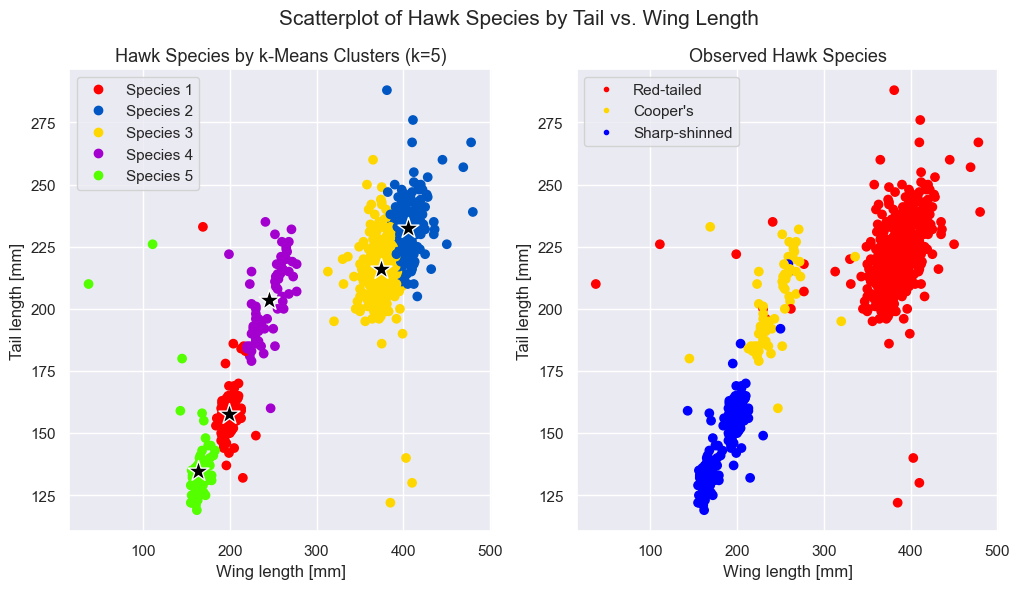

In [9]:
plot_hawk_kmeans(sk_kmeans, X, y)
plt.show()

In general, *k*-means clustering understands my data well. If we consider each cluster as 1 species, however, some species have 2 clusters associated with them. Perhaps these multiple clusters are able to address some of the cases that deviate from their respective main cluster under the 3 species categorization, though. 

Since I know the true labels (again, in an unsupervised learning setting, I would not know and be unable to do this), I can evaluate the perfomance of *k*-means clustering through classification accuracy.

In [10]:
# Map the cluster labels to the species names
species_nums = {0: "SS", 1: "RT", 2: "RT", 3: "CH", 4: "SS"}
# the predicted labels for the data points can be obtained with sk_kmeans.labels_
y_pred = np.array(list(map(lambda i : species_nums[i], sk_kmeans.labels_)))

In [11]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          CH       0.86      0.86      0.86        69
          RT       0.99      0.98      0.99       567
          SS       0.97      0.98      0.97       255

    accuracy                           0.97       891
   macro avg       0.94      0.94      0.94       891
weighted avg       0.97      0.97      0.97       891



Accuracy is high, and precision and recall are generally high across all species. To understand the accuracy and misclassifications further, let me display the values in a confusion matrix.

In [12]:
def plot_hawk_confusion_matrix(y_actual, y_pred):
    """
    Plots the confusion matrix given the actual and predicted values
    to easily view accurate classifications and type I/II errors
    """             
    # Obtain confusion matrix
    classes = ["RT", "CH", "SS"]
    cf_matrix = confusion_matrix(y_actual, y_pred, labels = classes)

    # View the confusion matrix using the seaborn package
    plt.figure(figsize = (6, 4))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Hawk Species Confusion Matrix', fontsize = 14)
    ax.set_xlabel("Predicted Label", fontsize = 12)
    ax.set_xticklabels(classes)
    ax.set_ylabel("True Label", fontsize = 12)
    ax.set_yticklabels(classes, rotation = 0)

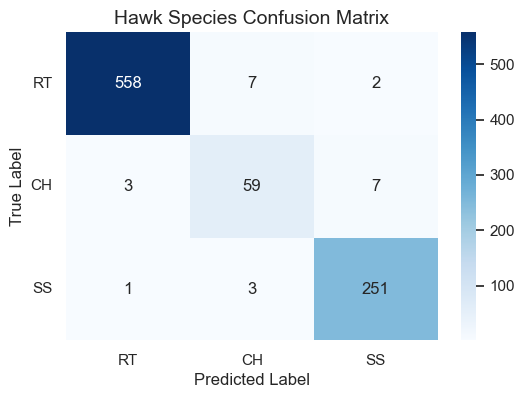

In [13]:
plot_hawk_confusion_matrix(y, y_pred)

In general, *k-means* clustering (and then reducing the 5 categories into the 3 species) was able to pick up the trends in the hawks data well!

### Perform *k*-means clustering (*k* = 3)

Based on the elbow method, the optimal *k* is 5, but I know that there are 3 clusters for the 3 different species in my data. Thus, I will run *k*-means clustering with 3 clusters/centroids and compare the results.

In [14]:
sk_kmeans2 = KMeans(n_clusters = 3, random_state = 42)
sk_kmeans2 = sk_kmeans2.fit(X)

# Per documentation, score() ouputs opposite of the value of X on the k-means objective.
sk_kmeans2.score(X) * -1

554072.3055115864

Inertia is nearly double that from when $k=5$. But does this mean that model will do worse? Let's visualize the clusters.

In [15]:
# Print the cluster centers
print(sk_kmeans2.cluster_centers_)

[[243.73333333 203.10666667]
 [386.34759358 222.24420677]
 [182.30666667 146.28235294]]


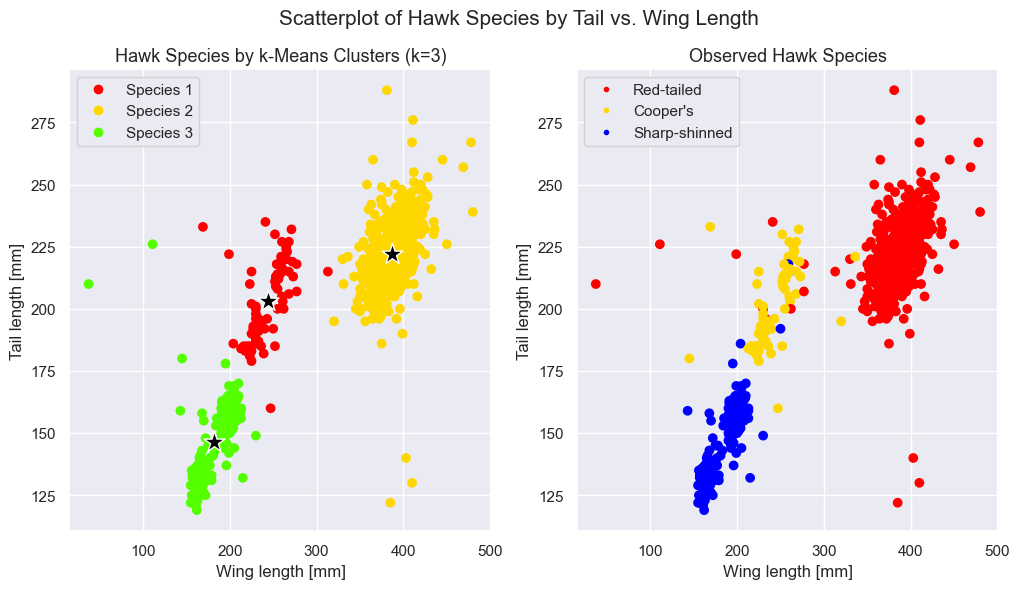

In [16]:
plot_hawk_kmeans(sk_kmeans2, X, y)
plt.show()

Using $k=3$, *k*-means clustering understands my data well. Each cluster can be mapped to 1 species.

Again, since I know the true labels (again, in an unsupervised learning setting, I would not know and be unable to do this), I can evaluate the perfomance of *k*-means clustering through classification accuracy.

In [17]:
species_nums2 = {0: "CH", 1: "RT", 2: "SS"}
y_pred2 = np.array(list(map(lambda i : species_nums2[i], sk_kmeans2.labels_)))

In [18]:
print(classification_report(y, y_pred2))

              precision    recall  f1-score   support

          CH       0.84      0.91      0.87        69
          RT       0.99      0.98      0.99       567
          SS       0.98      0.98      0.98       255

    accuracy                           0.98       891
   macro avg       0.94      0.96      0.95       891
weighted avg       0.98      0.98      0.98       891



Accuracy is high, and precision and recall are generally high across all species. To understand the accuracy and misclassifications further, let me display the values in a confusion matrix. 

While precision for Cooper's hawks went down slightly, there is a slight increase in all other metrics, suggesting that using $k=3$ produces better results than when $k=5$.

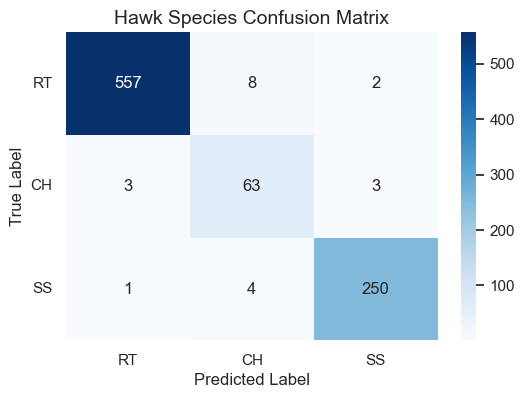

In [19]:
plot_hawk_confusion_matrix(y, y_pred2)

Looking at the confusion matrix, compared to when $k=5$, there are slightly fewer misclassifications, but the general trend in terms of accuracy and type of classification error persists.

### Comparing *k* = 5 & *k* = 3

Using a higher value of *k* in *k*-means clustering can lead to overfitting because it can create more clusters than necessary to capture the underlying patterns in the data. For my hawks data, I saw that 5 clusters was excessive in capturing the patterns in the hawks data, since there are only 3 species of hawks. Running classification accuracy diagnostics, I found that using $k=3$ had better predictive performance too.

However, it is important to note that **in unsupervised learning, you don't have labels for the data**. Because I knew what hawk species each observation was, I could tell that using $k=3$ would produce the best results, as I have 3 species that nicely follow 3 main clusters. I could even use these labels to produce a classification report and confusion matrix. In reality, one might have to proceed with $k=5$, because without any further data, it would be the best model to proceed with based on metrics such as inertia.

## Implementing *k*-means clustering: a custom class

Now I will implement *k*-means clustering from scratch, creating this custom class with all the necessary functionalities outlined by the algorithm, found in the `README.md` file of this k-means_clustering directory.

In [20]:
class kMeansClustering:
    """
    A custom class that implements k-means clustering.
    ...

    Attributes
    ----------
    k (int): the number of clusters desired
    centroids (numpy array): the centroids of the final clusters
    clusters (list): the clusters each data point was assigned to
    """

    def fit(self, X, k, max_iterations = 100):
        """
        Run k-means clustering on the input data X. Obtained centroids and 
        clusters are stored as attributes of the class.

        Parameters:
        -----------
        X: numpy array of the input data to cluster
        k: int representing the number of clusters to create
        max_iterations: optional int for the maximum number of iterations
        """
        self.k = k
        # Randomly initialize the centroids
        centroids = X[np.random.choice(X.shape[0], k, replace=False), :]
        # Assign each point to the closest cluster
        clusters = self.assign_all_points_to_clusters(X, centroids)
        counter = 0
        while counter < max_iterations:
            # Compute the new centroids based on the current clusters
            new_centroids = self.get_new_centroids(X, clusters)
            if not self.centroids_changed(centroids, new_centroids):
                break
            # Update the centroids and re-assign each point to the closest cluster
            centroids = new_centroids
            clusters = self.assign_all_points_to_clusters(X, centroids)
            counter += 1
        # Final centroids and cluster assignments are stored as attributes
        self.centroids = np.array([c[0] for c in centroids])
        self.clusters = clusters
    
    def assign_all_points_to_clusters(self, X, centroids):
        """
        Given a dataset X and a list of centroids, 
        returns a list of the cluster indices to which each point in X belongs.
        """
        clusters = []
        for x in X:
            clusters.append(self.assign_point_to_cluster(x, centroids))
        return clusters
    
    def assign_point_to_cluster(self, x, centroids):
        """
        Given a point x and a list of centroids, 
        returns the index of the cluster to which the point x belongs.
        """
        return self.closest_centroid(x, centroids)
    
    def closest_centroid(self, x, centroids):
        """
        Given a point x and a list of centroids, 
        returns the index of the closest centroid to the point x.
        """
        distances = self.distance_to_all_centroids(x, centroids)
        return np.argmin(distances)
    
    def get_new_centroids(self, X, clusters):
        """
        Returns the new centroids based on the clusters they belong to.
        """
        new_centroids = []
        for cluster in range(self.k):
            if len(X[clusters == cluster]) > 0:
                new_centroids.append(np.mean(X[clusters == cluster], axis=0))
            else:
                new_centroids.append(X[np.random.choice(X.shape[0], 1), :])
        return new_centroids

    def centroids_changed(self, old_centroids, new_centroids):
        """
        Determines if the centroids have changed from the previous iteration.
        """
        return not np.array_equal(old_centroids, new_centroids)
    
    def distance(self, x1, x2):
        """
        Helper function to calculate the Euclidean distance between two vectors
        """
        return np.linalg.norm(x1 - x2)

    def distance_to_centroid(self, x, centroid):
        """
        Helper function to calculate the Euclidean distance between a vector and centroid
        """
        return self.distance(x, centroid)

    def distance_to_all_centroids(self, x, centroids):
        """
        Helper function to calculate the Euclidean distance between a vector and all centroids
        """
        distances = []
        for centroid in centroids:
            distances.append(self.distance_to_centroid(x, centroid))
        return distances
    
    def wcss(self, X):
        """
        Calculates the within-cluster sum of squares (WCSS) for the given data X.
        """
        wcss = 0
        for i in range(len(X)):
            wcss += self.distance_to_centroid(X[i], self.centroids[self.clusters[i]])
        return wcss

Let's see it in action! Initialize an instance of this custom class:

In [21]:
# My class takes the data as a numpy.ndarray, so we need to convert the dataframe
X_np = X.to_numpy()

my_kmc = kMeansClustering()

### Example of 1st iteration 

Before fitting the model, let's look at what happens when *k*-means clustering is set up. In the first iteration, the centroids are randomly assigned, and the clusters are based on these initial random centroids. For example, in the plot below, the centroids look random, and we know they are not representative of the clusters in the data.

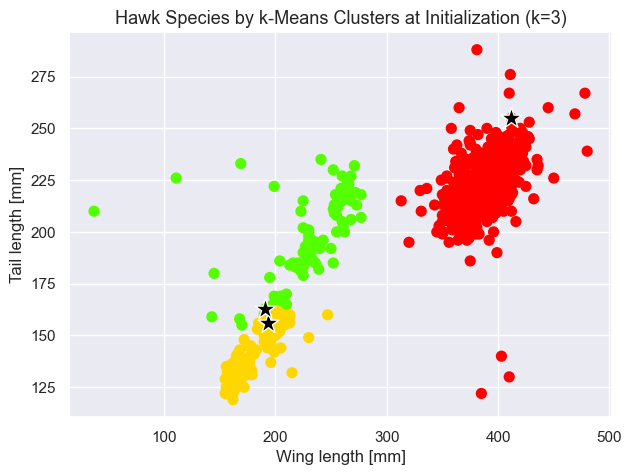

In [22]:
# Randomly find 3 data points from X
centroids = X_np[np.random.choice(X_np.shape[0], 3, replace=False), :]
iteration_one = my_kmc.assign_all_points_to_clusters(X_np, centroids)

# Plot initial clusters
plt.figure(figsize=(7, 5))
plt.scatter(X_np[:, 0], X_np[:, 1], c = iteration_one, s = 50, cmap = "prism")
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s = 250, c = "black", edgecolors = "white")
plt.xlabel("Wing length [mm]")
plt.ylabel("Tail length [mm]")
plt.title(f"Hawk Species by k-Means Clusters at Initialization (k=3)", fontsize = 13)
plt.show()
plt.show()

### Final results

Now let's see the results of *k*-means clustering after many iterations. I know that a good hyperparameter value is `k=3` so I will proceed with this value to see if I get the same results.

In [23]:
my_kmc.fit(X_np, 3, 100)

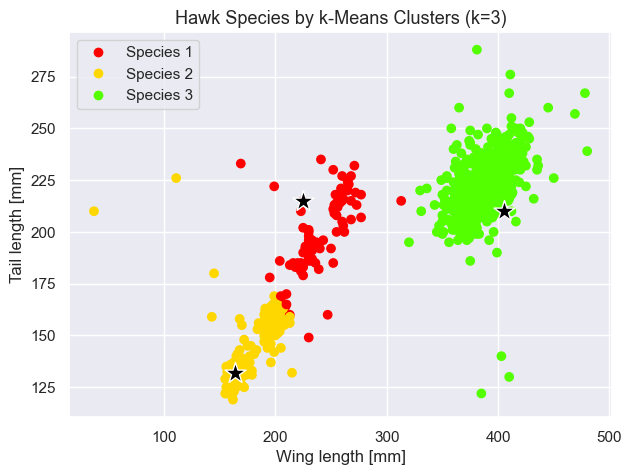

In [24]:
plt.figure(figsize = (7, 5))
scatter1 = plt.scatter(X_np[:, 0], X_np[:, 1], c = my_kmc.clusters, cmap = "prism") 
handles = scatter1.legend_elements()[0]
plt.legend(fontsize = 11, loc = "upper left", handles = handles,
           labels = ["Species " + str(i+1) for i in range(0, my_kmc.k)])
plt.scatter(my_kmc.centroids[:,0], my_kmc.centroids[:,1], marker='*', s = 250, c = "black", edgecolors = "white")
plt.grid(True)
plt.xlabel("Wing length [mm]")
plt.ylabel("Tail length [mm]")
plt.title(f"Hawk Species by k-Means Clusters (k={my_kmc.k})", fontsize = 13)
plt.show()

In this plot, while it seems they haven't stabilized yet (I did only run for 100 iterations), the clusters are much more representative of the clusters in my data and those found using scikit-learn compared to at initialization. Thus, *k*-means clustering was able to discern the different species, and my custom class also gave me more insight into the behind-the-scenes as well.

### Evaluating Performance

One way to evaluate the quality of clustering in *k*-means clustering is through a measure called the within-cluster sum of squares (WCSS). The WCSS value is the sum of the squared distances between each data point and its assigned centroid in the cluster. The goal of *k*-means clustering is to minimize the WCSS value, as this indicates that the data points within each cluster are as close to each other as possible, and as far from the data points in other clusters as possible.

By comparing the WCSS values for different *k* values (number of clusters), one can determine the optimal number of clusters for a given dataset. The elbow method as I performed previously is a common technique used to determine the optimal number of clusters. By plotting the WCSS values for different *k* values and looking for the "elbow" point where the improvement in WCSS starts to level off, one can determine the optimal value for this hyperparameter. Here, I will just compare the WCSS under two different hyperparameters.

I have a function to compute the WCSS in my class. Let's look at it for `k=3` vs `k=5`.

In [25]:
my_kmc.wcss(X_np)

26484.18463229261

In [26]:
my_kmc2 = kMeansClustering()
my_kmc2.fit(X_np, 5, 100)
my_kmc2.wcss(X_np)

28672.881015349205

Since the WCSS is higher when `k=5`, *k*-means clustering is best performed with 3 clusters for this dataset.

In general, as the value of *k* increases, the WCSS decreases. This is because with a larger number of clusters, each cluster tends to have fewer points, and the centroids of the clusters are closer to the data points. Adding too many clusters also can result in overfitting, so as discovered using scikit-learn, this confirms we are good to go with the `k=3` model!